# Preparando ambiente

In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Carregando dados

In [2]:
osorio = pd.read_csv('https://raw.githubusercontent.com/SalatielBairros/dias-tipicos/main/data/pv_dia_osorio_2019.csv')
osorio

,local_time,irradiance_direct,irradiance_diffuse,temperature
0,2019-01-01 06:00:00,0.000,0.012,23.489
1,2019-01-01 07:00:00,0.000,0.091,24.256
2,2019-01-01 08:00:00,0.094,0.155,25.190
3,2019-01-01 09:00:00,0.235,0.195,26.237
4,2019-01-01 10:00:00,0.304,0.255,27.130
...,...,...,...,...
4740,2019-12-31 14:00:00,0.166,0.400,30.495
4741,2019-12-31 15:00:00,0.065,0.343,29.996
4742,2019-12-31 16:00:00,0.050,0.293,29.550
4743,2019-12-31 17:00:00,0.037,0.231,29.056


# Preparando dados

In [3]:
osorio.dtypes

local_time             object
irradiance_direct     float64
irradiance_diffuse    float64
temperature           float64
dtype: object

In [4]:
osorio['local_time'] = pd.to_datetime(osorio['local_time'])
print(osorio.dtypes)
osorio.sample(5)

local_time            datetime64[ns]
irradiance_direct            float64
irradiance_diffuse           float64
temperature                  float64
dtype: object


,local_time,irradiance_direct,irradiance_diffuse,temperature
1904,2019-05-27 12:00:00,0.015,0.175,19.954
357,2019-01-28 12:00:00,0.827,0.144,30.969
911,2019-03-12 07:00:00,0.002,0.061,21.416
1997,2019-06-03 14:00:00,0.067,0.197,17.537
325,2019-01-26 06:00:00,0.000,0.006,22.700


# Separando a data e períodos

In [5]:
new_dates, new_times = zip(*[(d.date(), d.hour) for d in osorio['local_time']])
osorio = osorio.assign(new_date=new_dates, new_time=new_times)
del osorio['local_time']
osorio.rename(columns={'new_date': 'date', 'new_time': 'time'}, inplace=True)
osorio.sample(5)

,irradiance_direct,irradiance_diffuse,temperature,date,time
1364,0.000,0.000,21.497,2019-04-15,18
804,0.098,0.081,24.555,2019-03-03,17
3470,0.001,0.005,16.074,2019-09-24,18
2688,0.007,0.055,17.375,2019-07-26,16
2,0.094,0.155,25.190,2019-01-01,8


In [6]:
def obter_periodo(hora):
    if(0 <= hora < 6):
        return 'madrugada'
    if(6 <= hora < 12):
        return 'manhã'
    if(12 <= hora < 18):
        return 'tarde'
    if(18 <= hora < 24):
        return 'noite'

In [7]:
osorio['periodo'] = [obter_periodo(hora) for hora in osorio['time']]
osorio.groupby(['date', 'periodo']).mean()

irradiance_direct  irradiance_diffuse  temperature  time
date       periodo                                                          
2019-01-01 manhã             0.172167            0.165000    25.703333   8.5
           noite             0.030000            0.155000    27.642000  18.0
           tarde             0.464000            0.228833    28.932833  14.5
2019-01-02 manhã             0.277833            0.108667    26.207667   8.5
           noite             0.045000            0.147000    29.690000  18.0
...                               ...                 ...          ...   ...
2019-12-30 noite             0.080000            0.121000    28.272000  18.0
           tarde             0.637167            0.137667    29.920167  14.5
2019-12-31 manhã             0.284000            0.114167    26.177000   8.5
           noite             0.014000            0.149000    28.214000  18.0
           tarde             0.210667            0.314000    30.121500  14.5

[1095 rows x 4 columns]

# Transformando períodos em atributos

In [38]:
dias = []
for i in osorio.groupby('date'):
    d = {
        'data': i[0],
        # 'idr_madrugada': i[1][i[1]['periodo'] == 'madrugada']['irradiance_direct'].mean(),
        # 'idf_madrugada': i[1][i[1]['periodo'] == 'madrugada']['irradiance_diffuse'].mean(),
        # 'tmp_madrugada': i[1][i[1]['periodo'] == 'madrugada']['temperature'].mean(),

        'idr_manha': i[1][i[1]['periodo'] == 'manhã']['irradiance_direct'].mean(),
        'idr_tarde': i[1][i[1]['periodo'] == 'tarde']['irradiance_direct'].mean(),
        'idf_manha': i[1][i[1]['periodo'] == 'manhã']['irradiance_diffuse'].mean(),
        'idf_tarde': i[1][i[1]['periodo'] == 'tarde']['irradiance_diffuse'].mean(),
        'tmp_manha': i[1][i[1]['periodo'] == 'manhã']['temperature'].mean(),
        'tmp_tarde': i[1][i[1]['periodo'] == 'tarde']['temperature'].mean(),
        
        # 'idr_noite': i[1][i[1]['periodo'] == 'noite']['irradiance_direct'].mean(),
        # 'idf_noite': i[1][i[1]['periodo'] == 'noite']['irradiance_diffuse'].mean(),        
        # 'tmp_noite': i[1][i[1]['periodo'] == 'noite']['temperature'].mean()        
    }
    dias.append(d)

df_periodo = pd.DataFrame(dias)
print(df_periodo.shape)
df_periodo

(365, 7)


,data,idr_manha,idr_tarde,idf_manha,idf_tarde,tmp_manha,tmp_tarde
0,2019-01-01,0.172167,0.464000,0.165000,0.228833,25.703333,28.932833
1,2019-01-02,0.277833,0.568667,0.108667,0.176500,26.207667,31.356500
2,2019-01-03,0.004000,0.022833,0.131833,0.300333,26.989833,25.183833
3,2019-01-04,0.255500,0.547667,0.120333,0.187500,21.721000,24.702000
4,2019-01-05,0.223000,0.466500,0.134833,0.221167,21.689167,24.411333
...,...,...,...,...,...,...,...
360,2019-12-27,0.068000,0.493667,0.195833,0.213333,24.660833,28.247000
361,2019-12-28,0.317167,0.673500,0.082833,0.120667,25.077500,29.325167
362,2019-12-29,0.061667,0.387833,0.202333,0.258167,24.863333,30.292000
363,2019-12-30,0.312333,0.637167,0.086500,0.137667,25.555667,29.920167


In [39]:
df_periodo.dropna(inplace=True)
print(df_periodo.shape)

(365, 7)


In [40]:
X = df_periodo.drop(columns=['data'])

# Treinando com KMeans

In [41]:
faixa_clusters = [i for i in range(2, 20)]
valores_silhueta = []

for n in faixa_clusters:
    agrupador = KMeans(n_clusters=n)
    labels = agrupador.fit_predict(X)
    media = silhouette_score(X, labels)
    values, counts = np.unique(labels, return_counts=True)
    print((n, media, counts))
    print('\n')

(2, 0.5216005749254824, array([131, 234]))


(3, 0.49506339033136854, array([106, 173,  86]))


(4, 0.46654102902576144, array([ 82,  91,  41, 151]))


(5, 0.44089171596016036, array([ 86,  32,  57,  73, 117]))


(6, 0.40656946447042225, array([58, 94, 29, 45, 72, 67]))


(7, 0.3895517845738826, array([59, 62, 20, 74, 45, 29, 76]))


(8, 0.36428497113971353, array([29, 57, 35, 20, 53, 82, 57, 32]))


(9, 0.33614001063142396, array([39, 37, 70, 69, 18, 21, 24, 40, 47]))


(10, 0.35027514748730254, array([43, 61, 46,  7, 21, 16, 51, 53, 41, 26]))


(11, 0.33155930112282317, array([34, 52, 49, 14, 19, 45,  9, 41, 37, 23, 42]))


(12, 0.33852546464124944, array([45, 14, 19, 53, 32, 39, 48, 36,  9, 23, 26, 21]))


(13, 0.3364001775158249, array([38, 23, 42,  7, 40, 42, 14, 43, 25, 15, 38, 18, 20]))


(14, 0.33975041342226703, array([28, 31, 41, 15, 16, 33, 34,  7, 24, 23, 28, 20, 26, 39]))


(15, 0.3496248696728231, array([23, 24, 28, 16, 22, 37, 29, 27, 36,  8, 28, 29,  7, 19, 32]))


(16,

# Treinando com DBSCAN

In [25]:
faixa_eps = [0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 5, 10]
valores_silhueta = []
for n in faixa_eps:
    agrupador = DBSCAN(eps=n, min_samples=30)
    labels = agrupador.fit_predict(X)
    if(len(np.unique(labels)) > 1):
        media = silhouette_score(X, labels)
        print((n, media, np.unique(labels, return_counts=True)))
        print('\n')

(1.1, -0.02423237457419733, (array([-1,  0]), array([272,  93])))


(1.3, 0.2563647405493863, (array([-1,  0]), array([173, 192])))


(1.5, 0.10322256688045854, (array([-1,  0,  1,  2]), array([ 86, 225,  30,  24])))




# `MinMaxScaler`

In [28]:
mm_scaler = MinMaxScaler()
mm_X = mm_scaler.fit_transform(X)
mm_X

array([[0.31970849, 0.625     , 0.86037316, 0.62030411, 0.57319699,
        0.84211099],
       [0.52059569, 0.33758503, 0.88312059, 0.76073345, 0.40419806,
        0.94754434],
       [0.        , 0.45578231, 0.91839941, 0.02839893, 0.80409042,
        0.67902353],
       ...,
       [0.10963245, 0.81547619, 0.82248583, 0.5181127 , 0.6679225 ,
        0.9012369 ],
       [0.58618504, 0.2244898 , 0.85371281, 0.85263864, 0.2787944 ,
        0.88506155],
       [0.53231939, 0.36564626, 0.8817374 , 0.28041145, 0.8482239 ,
        0.89381987]])

In [29]:
valores_silhueta = []

for n in faixa_clusters:
    agrupador = KMeans(n_clusters=n)
    labels = agrupador.fit_predict(mm_X)
    media = silhouette_score(mm_X, labels)
    values, counts = np.unique(labels, return_counts=True)
    print((n, media, counts))
    print('\n')

(2, 0.4141344327936777, array([168, 197]))


(3, 0.3686349236233441, array([ 75, 186, 104]))


(4, 0.3075158569609696, array([ 73, 117,  99,  76]))


(5, 0.30052692154175403, array([ 54,  75,  64,  67, 105]))


(6, 0.26360930252711146, array([57, 67, 85, 53, 65, 38]))


(7, 0.24785552480119397, array([41, 58, 54, 60, 45, 39, 68]))


(8, 0.2594217041850075, array([36, 43, 40, 46, 38, 49, 64, 49]))


(9, 0.2741320694436857, array([19, 52, 49, 47, 34, 49, 35, 44, 36]))


(10, 0.2751114542770997, array([45, 50, 47, 27, 30, 34, 36, 37, 19, 40]))


(11, 0.26802502699078623, array([34, 38, 34, 37, 34, 40, 33, 19, 34, 34, 28]))


(12, 0.26860963846964186, array([29, 34, 30, 31, 37, 41, 33, 18, 27, 36, 23, 26]))


(13, 0.2647051433354771, array([30, 25, 28, 42, 19, 27, 22, 29, 34, 17, 33, 22, 37]))


(14, 0.26450207057556546, array([46, 32, 33, 28, 21, 28, 33, 14, 28, 15, 25, 24, 16, 22]))


(15, 0.2682161598913934, array([30, 33, 10, 28, 21, 30, 28, 22, 16, 28, 28, 31, 15, 25, 20]))


(16, 0.2

# `StandardScaler`

In [30]:
std_scaler = StandardScaler()
std_X = std_scaler.fit_transform(X)
std_X

array([[-0.49926478,  0.98329687,  1.40968107,  0.49744453,  0.92930475,
         1.47760262],
       [ 0.16776482, -0.17684749,  1.52797969,  0.96638288,  0.23578742,
         2.01970377],
       [-1.5608308 ,  0.3002533 ,  1.71144811, -1.47911568,  1.87681727,
         0.63906437],
       ...,
       [-1.19680519,  1.75214993,  1.21264702,  0.15619481,  1.31802784,
         1.78160722],
       [ 0.38554893, -0.633354  ,  1.37504374,  1.27328362, -0.27882894,
         1.69843932],
       [ 0.20669241, -0.06357896,  1.52078639, -0.63756549,  2.0579269 ,
         1.74347151]])

In [31]:
valores_silhueta = []

for n in faixa_clusters:
    agrupador = KMeans(n_clusters=n)
    labels = agrupador.fit_predict(std_X)
    media = silhouette_score(std_X, labels)
    values, counts = np.unique(labels, return_counts=True)
    print((n, media, counts))
    print('\n')

(2, 0.3608490257652825, array([196, 169]))


(3, 0.3312546942201311, array([119, 109, 137]))


(4, 0.34210642517416484, array([ 76,  58,  94, 137]))


(5, 0.29408854013095526, array([78, 89, 77, 45, 76]))


(6, 0.2788075594417613, array([62, 52, 41, 61, 78, 71]))


(7, 0.2677267731819485, array([51, 48, 41, 42, 74, 50, 59]))


(8, 0.2593416326509463, array([57, 36, 38, 40, 30, 52, 44, 68]))


(9, 0.24461891261410273, array([43, 44, 24, 44, 48, 49, 42, 50, 21]))


(10, 0.2427767154743327, array([28, 48, 19, 36, 39, 31, 47, 42, 36, 39]))


(11, 0.2560921260632078, array([39, 38, 35, 56, 33, 20, 16, 26, 29, 28, 45]))


(12, 0.25875664258097947, array([34, 28, 34, 20, 32, 51, 40, 32, 16, 24, 30, 24]))


(13, 0.2541722128980727, array([32, 21, 25, 35, 25, 16, 32, 34, 24, 27, 34, 35, 25]))


(14, 0.2529261533656019, array([27, 23, 28, 24, 14, 41, 28, 10, 26, 34, 15, 34, 29, 32]))


(15, 0.24355764399863478, array([18, 39, 22, 28, 22,  9, 27, 25, 22, 28, 33, 30, 15, 23, 24]))


(16, 0.2572810

# Análises dos centróides dos melhores resultados

In [42]:
agrupador = KMeans(n_clusters=2)
labels = agrupador.fit_predict(X)
media = silhouette_score(X, labels)
values, counts = np.unique(labels, return_counts=True)
print((media, counts))

(0.5216005749254824, array([131, 234]))


In [43]:
agrupador.cluster_centers_

array([[ 0.24902163,  0.31512977,  0.09996565,  0.11944529, 15.22995802,
        17.62806616],
       [ 0.25250855,  0.37415527,  0.12693234,  0.18068732, 22.19239744,
        24.95706339]])

In [44]:
pd.DataFrame(data=agrupador.cluster_centers_, columns=X.columns)

,idr_manha,idr_tarde,idf_manha,idf_tarde,tmp_manha,tmp_tarde
0,0.249022,0.315130,0.099966,0.119445,15.229958,17.628066
1,0.252509,0.374155,0.126932,0.180687,22.192397,24.957063


Analisando somente esses dados parecem existir dois tipos de dias: Os mais frios e com menos luminosidade e os mais quentes e com mais luminosidade.

In [45]:
X.describe()

,idr_manha,idr_tarde,idf_manha,idf_tarde,tmp_manha,tmp_tarde
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,0.251257,0.352971,0.117254,0.158707,19.693549,22.326656
std,0.158631,0.223506,0.048624,0.075564,4.269075,4.477012
min,0.004000,0.001667,0.042500,0.051333,6.628000,9.574667
25%,0.106000,0.142833,0.077833,0.101500,17.205167,19.409500
50%,0.265333,0.375000,0.107667,0.138833,20.167667,22.568167
75%,0.377000,0.537333,0.153667,0.200667,22.637667,25.455167
max,0.530000,0.747000,0.238500,0.361000,28.799000,32.562333


In [51]:
corr = X.corr()
corr

,idr_manha,idr_tarde,idf_manha,idf_tarde,tmp_manha,tmp_tarde
idr_manha,1.000000,0.772893,-0.664743,-0.582526,-0.099789,0.080883
idr_tarde,0.772893,1.000000,-0.612156,-0.535140,-0.029241,0.190548
idf_manha,-0.664743,-0.612156,1.000000,0.851841,0.401106,0.229326
idf_tarde,-0.582526,-0.535140,0.851841,1.000000,0.511791,0.373186
tmp_manha,-0.099789,-0.029241,0.401106,0.511791,1.000000,0.941214
tmp_tarde,0.080883,0.190548,0.229326,0.373186,0.941214,1.000000


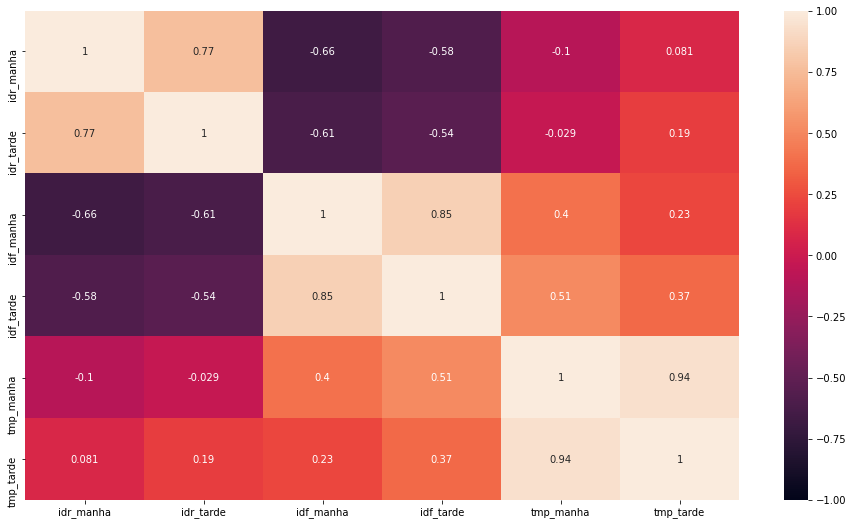

In [52]:
plt.figure(figsize=(16, 9))
sns.heatmap(corr, vmin=-1, vmax=1, annot=True);

O próximo passo será acrescentar o vento por período e a eletrecidade como uma variável de vínculo geral do dia.

# Salvando o dataset gerado

In [54]:
df_periodo

,data,idr_manha,idr_tarde,idf_manha,idf_tarde,tmp_manha,tmp_tarde
0,2019-01-01,0.172167,0.464000,0.165000,0.228833,25.703333,28.932833
1,2019-01-02,0.277833,0.568667,0.108667,0.176500,26.207667,31.356500
2,2019-01-03,0.004000,0.022833,0.131833,0.300333,26.989833,25.183833
3,2019-01-04,0.255500,0.547667,0.120333,0.187500,21.721000,24.702000
4,2019-01-05,0.223000,0.466500,0.134833,0.221167,21.689167,24.411333
...,...,...,...,...,...,...,...
360,2019-12-27,0.068000,0.493667,0.195833,0.213333,24.660833,28.247000
361,2019-12-28,0.317167,0.673500,0.082833,0.120667,25.077500,29.325167
362,2019-12-29,0.061667,0.387833,0.202333,0.258167,24.863333,30.292000
363,2019-12-30,0.312333,0.637167,0.086500,0.137667,25.555667,29.920167


In [55]:
df_periodo.to_csv('pv_dia_osorio_2019_periodos.csv')